In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_fscore_support, auc as auc_score
)
import math
import os
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Loading the dataset 

In [2]:
df = pd.read_csv("../data/transactions.csv")

# STEP 2:  DATA PREPROCESSING


2.1 first we sort the dataset according to chronology i.e. we sort it based on time as anomalies are computed strictly from past data and prevent leak of future during the train test split 

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.sort_values("timestamp").reset_index(drop=True)

2.2 now we drop rows and columns based on the following- 
 - if amount<0
 - if hour is not present in [0,23] 
 - day_of_the_week must be present between [0,6] if not we drop
 - if month is not present between [1,12]
 - duplicates
 - we drop any unique value identifier columns as they don't carry predictive pattern information

# ITERATION4: PROBLEM FIX: removed is fraud label leakage

In [4]:
df = df[df["amount"] > 0]
df = df[(df["hour"] >= 0) & (df["hour"] <= 23)]
df = df[(df["day_of_week"] >= 0) & (df["day_of_week"] <= 6)]
df = df[(df["month"] >= 1) & (df["month"] <= 12)]
df = df.drop_duplicates()
y = df["is_fraud"].astype(int).reset_index(drop=True) 
df = df.drop(columns=["is_fraud"]) # fixed
drop_cols = ["transaction_id","card_number","customer_id","merchant_id","timestamp","fraud_type"]
df = df.drop(columns=drop_cols)

# ITERATION 4: PROBLEM IDENTIFIED: Label leakage 

In [5]:
# 1) Are we accidentally leaving 'is_fraud' in the features?
print("'is_fraud' in df columns?", 'is_fraud' in df.columns)

'is_fraud' in df columns? False


In [6]:
df

,amount,merchant_category,merchant_lat,merchant_long,hour,day_of_week,month,distance_from_home
0,22779.74,jewelry,19.128865,72.902100,0,2,1,847.23
1,62609.57,electronics,19.009754,72.828282,0,2,1,1036.73
2,2155.20,gas,12.934345,77.606382,0,2,1,1566.57
3,344.87,grocery,28.705806,77.098609,0,2,1,1752.77
4,1271.03,restaurant,12.970154,77.615085,0,2,1,840.52
...,...,...,...,...,...,...,...,...
99995,13909.13,jewelry,28.652728,77.127274,23,6,3,1765.79
99996,23845.01,luxury_goods,13.041175,80.205535,23,6,3,1771.48
99997,1744.53,grocery,19.083755,72.912571,23,6,3,862.94
99998,1346.82,restaurant,19.053875,72.884754,23,6,3,5.72


2.3 Feature Engineering

- Since time is cricular i.e. 23hours is not far away from 0 hours so cyclical encoding using sine and cosine transformations is applied to preserve circular geometry rather than linear 

In [7]:
def cyclical(col, max_val):
    return (
        np.sin(2*np.pi*df[col]/max_val),
        np.cos(2*np.pi*df[col]/max_val)
    )

df["hour_sin"], df["hour_cos"] = cyclical("hour", 24)
df["day_sin"], df["day_cos"] = cyclical("day_of_week", 7)
df["month_sin"], df["month_cos"] = cyclical("month", 12)

df = df.drop(columns=["hour","day_of_week","month"])


In [8]:
df 

,amount,merchant_category,merchant_lat,merchant_long,distance_from_home,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,22779.74,jewelry,19.128865,72.902100,847.23,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
1,62609.57,electronics,19.009754,72.828282,1036.73,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
2,2155.20,gas,12.934345,77.606382,1566.57,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
3,344.87,grocery,28.705806,77.098609,1752.77,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
4,1271.03,restaurant,12.970154,77.615085,840.52,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...
99995,13909.13,jewelry,28.652728,77.127274,1765.79,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99996,23845.01,luxury_goods,13.041175,80.205535,1771.48,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99997,1744.53,grocery,19.083755,72.912571,862.94,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99998,1346.82,restaurant,19.053875,72.884754,5.72,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17


- We apply log1p to amount and distance because anomaly models are distance-based without compression, extreme values dominate the geometry and the model collapses into a magnitude detector.

In [9]:
df["amount_log"] = np.log1p(df["amount"])
df["distance_log"] = np.log1p(df["distance_from_home"])

df = df.drop(columns=["amount","distance_from_home"])

2.4 CATEGORICAL ENCODING
- We one-hot encode merchant categories

In [10]:

if "merchant_category" in df.columns:
    df = pd.get_dummies(df, columns=["merchant_category"], drop_first=True)
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

- we drop any non-numeric columns because anomaly models operate purely in numeric geometry.

In [11]:
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Dropping non-numeric columns (unexpected):", non_numeric)
    df = df.drop(columns=non_numeric)

# STEP 3: Train Test Split
We perform a time-based 80% train, 20% test split because fraud detection models must learn from the past and predict the future. random splits would leak future fraud patterns and affect performance.

In [12]:
X_df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

n = len(X_df)
split_idx = int(math.floor(n * 0.8))
X_train_df = X_df.iloc[:split_idx].reset_index(drop=True)
X_test_df = X_df.iloc[split_idx:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test = y.iloc[split_idx:].reset_index(drop=True)


# STEP 4 : Data Normalization 
All numerical features are scaled using RobustScaler, which normalizes data based on median and interquartile range to reduce sensitivity to extreme outliers common in fraud datasets.

In [13]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_test_scaled = scaler.transform(X_test_df.values)

X_train = pd.DataFrame(X_train_scaled, columns=X_train_df.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_df.columns)

We remove the fraud samples to train autoencoders becuase Autoencoders must be trained only on normal data so they learn the normal manifold

In [14]:
X_train_ae = X_train[y_train == 0].values
X_test_ae = X_test.values

# STEP 5: Training Isolation Forest
Isolation Forest detects fraud by isolating rare behavior using random feature splits, and we set contamination to the known fraud rate to calibrate the anomaly threshold.

In [15]:
SEED = 42
FRAUD_RATE = 0.02  
iso_clf = IsolationForest(
    n_estimators=200,
    contamination=FRAUD_RATE, 
    random_state=SEED,
    n_jobs=-1
)

iso_clf.fit(X_train) 

IsolationForest(contamination=0.02, n_estimators=200, n_jobs=-1,
                random_state=42)

# ITERATION 2 
- we remove the fraud samples (see DECISION_LOG.md)

In [16]:
X_train_normal = X_train[y_train == 0]

print(f"OC-SVM training samples (normal only): {X_train_normal.shape}")

OC-SVM training samples (normal only): (78397, 16)


# Model2: Training One class SVM

In [17]:
ocsvm = OneClassSVM(
    kernel="rbf",      
    nu=FRAUD_RATE,     
    gamma="scale"      
)

ocsvm.fit(X_train_normal)


OneClassSVM(nu=0.02)

# Model3: Autoencoder Architecture
An undercomplete autoencoder is used to learn a compact representation of normal transaction behavior by compressing the input features into a low-dimensional latent space and reconstructing them using a symmetric decoder. The model is trained with mean squared error loss so that fraudulent transactions, which deviate from the learned normal manifold, produce higher reconstruction errors and can be detected as anomalies.


# ITERATION 3: Added another dense 128 unit layer
- REMOVED THE IRRELEVANT dense 128 layer 

In [18]:
input_dim = X_train_ae.shape[1]

input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(64, activation="relu")(input_layer)
x = Dense(32, activation="relu")(x)
latent = Dense(16, activation="relu")(x)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dense(64, activation="relu")(x)
output_layer = Dense(input_dim, activation="linear")(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392 (28.88 KB)

 Trainable params: 7,392 (28.88 KB)

 Non-trainable params: 0 (0.00 B)


# ITERATION3: Autoencoder Training with Early Stopping

- The autoencoder is trained only on legitimate transactions using reconstruction loss, with a validation split to monitor generalization performance. Early stopping is applied to halt training when validation loss stops improving, preventing overfitting and restoring the best-performing model weights.

In [19]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


history = autoencoder.fit(
    X_train_ae,
    X_train_ae,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1723 - val_loss: 0.0141
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1723 - val_loss: 0.0141
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9282e-04 - val_loss: 0.0014
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9282e-04 - val_loss: 0.0014
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3.0621e-04 - val_loss: 9.5118e-04
Epoch 7/50
276/276 ━━━━━━━━━━━━━

In [20]:
X_test_pred = autoencoder.predict(X_test_ae)
recon_error = np.mean(np.square(X_test_ae - X_test_pred), axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


# STEP 6: predictions and confusion matrix

Isolation forest metrics

In [21]:
pred_raw = iso_clf.predict(X_test)
y_pred = (pred_raw == -1).astype(int) 

anomaly_score = -iso_clf.decision_function(X_test)

print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))

prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



Confusion Matrix (test):
[[17685  1918]
 [  353    44]]

Classification report (test):
              precision    recall  f1-score   support

           0     0.9804    0.9022    0.9397     19603
           1     0.0224    0.1108    0.0373       397

    accuracy                         0.8864     20000
   macro avg     0.5014    0.5065    0.4885     20000
weighted avg     0.9614    0.8864    0.9218     20000


Precision: 0.0224, Recall: 0.1108, F1: 0.0373


One class SVM metrics

In [22]:
# Predictions
ocsvm_raw = ocsvm.predict(X_test)
ocsvm_pred = (ocsvm_raw == -1).astype(int)

ocsvm_scores = -ocsvm.decision_function(X_test)

print("\nOne-Class SVM Confusion Matrix:")
print(confusion_matrix(y_test, ocsvm_pred))

print("\nOne-Class SVM Classification Report:")
print(classification_report(y_test, ocsvm_pred, digits=4))
prec, recall, f1, _ = precision_recall_fscore_support(y_test, ocsvm_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



One-Class SVM Confusion Matrix:
[[18588  1015]
 [  338    59]]

One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0     0.9821    0.9482    0.9649     19603
           1     0.0549    0.1486    0.0802       397

    accuracy                         0.9324     20000
   macro avg     0.5185    0.5484    0.5226     20000
weighted avg     0.9637    0.9324    0.9473     20000


Precision: 0.0549, Recall: 0.1486, F1: 0.0802


In [23]:
# Compute train-normal recon errors once (used to set threshold)
train_pred = autoencoder.predict(X_train_ae)
recon_train = np.mean(np.square(X_train_ae - train_pred), axis=1)

# Choose threshold from training normals (no test peeking)
thr = np.percentile(recon_train, 100 * (1 - FRAUD_RATE))
ae_pred = (recon_error > thr).astype(int)

print(f"AE threshold (train-based) = {thr:.6e}")
print("Train-normal recon_error: mean, std =", recon_train.mean(), recon_train.std())

2450/2450 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step
AE threshold (train-based) = 8.453546e-05
Train-normal recon_error: mean, std = 1.4780698506393696e-05 0.00011433107133430303
AE threshold (train-based) = 8.453546e-05
Train-normal recon_error: mean, std = 1.4780698506393696e-05 0.00011433107133430303


Metrics for AutoEncoders

In [24]:
print("\nAutoencoder Confusion Matrix:")
print(confusion_matrix(y_test, ae_pred))

print("\nAutoencoder Classification Report:")
print(classification_report(y_test, ae_pred, digits=4))
prec, recall, f1, _ = precision_recall_fscore_support(y_test, ae_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Autoencoder Confusion Matrix:
[[16644  2959]
 [  320    77]]

Autoencoder Classification Report:
              precision    recall  f1-score   support

           0     0.9811    0.8491    0.9103     19603
           1     0.0254    0.1940    0.0449       397

    accuracy                         0.8360     20000
   macro avg     0.5032    0.5215    0.4776     20000
weighted avg     0.9622    0.8360    0.8931     20000


Precision: 0.0254, Recall: 0.1940, F1: 0.0449


### Precision–Recall Curve Comparison (Model Evaluation)

This visualization compares **Isolation Forest**, **One-Class SVM**, and **Autoencoder** using **Precision–Recall (PR) curves**, which are the most appropriate evaluation tool for **highly imbalanced fraud detection datasets**. Unlike accuracy or ROC curves, PR curves focus on the model’s ability to correctly identify rare fraud cases while controlling false positives.

Each curve is generated by varying the decision threshold on anomaly scores, and the **PR-AUC** summarizes overall ranking quality. This allows us to compare how well each model prioritizes fraudulent transactions across all thresholds, independent of a fixed cutoff. In this project, PR-AUC is used as the **primary model selection metric**, ensuring the chosen model performs well under real-world alerting and investigation constraints.


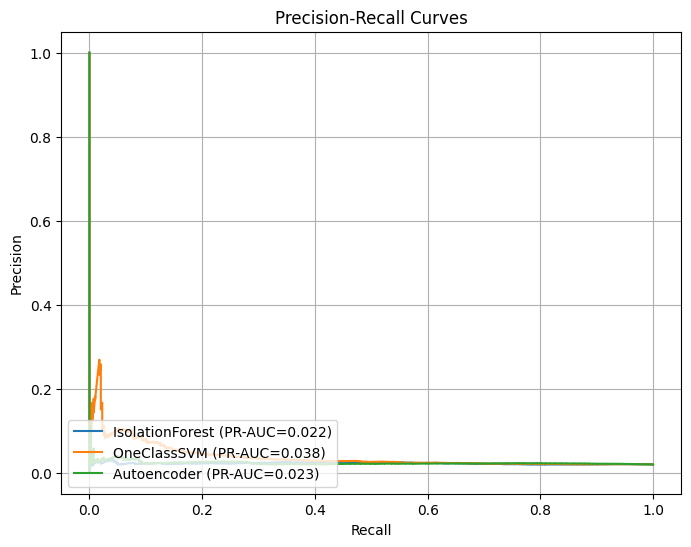

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

scores_map = {
    "IsolationForest": anomaly_score,
    "OneClassSVM": ocsvm_scores,
    "Autoencoder": recon_error
}

plt.figure(figsize=(8,6))
for name, scores in scores_map.items():
    p, r, _ = precision_recall_curve(y_test, scores)
    pr_auc = auc(r, p)
    plt.plot(r, p, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### ROC Curve Analysis (Secondary Evaluation)

This plot compares **Isolation Forest**, **One-Class SVM**, and **Autoencoder** using **Receiver Operating Characteristic (ROC) curves**, which illustrate the trade-off between **True Positive Rate (Recall)** and **False Positive Rate** across all possible thresholds. The diagonal line represents random performance, while curves closer to the top-left indicate better discrimination.

ROC-AUC is used here as a **secondary evaluation metric** to measure the models’ overall ability to separate fraudulent and legitimate transactions. While ROC-AUC can appear optimistic on highly imbalanced datasets, it still provides a useful sanity check and complements PR-AUC by confirming that the selected model has genuine ranking power rather than exploiting class imbalance artifacts.


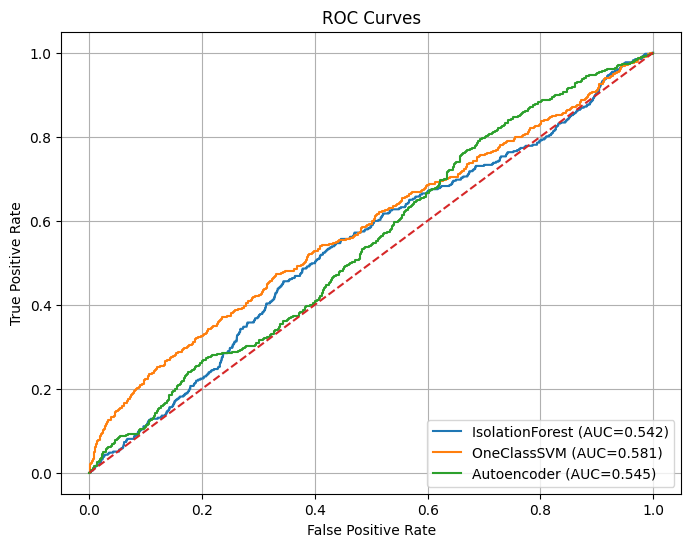

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, scores in scores_map.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Confusion Matrix Visualization (Threshold-Based Evaluation)

This visualization shows the **confusion matrices** for Isolation Forest, One-Class SVM, and Autoencoder using a **common decision threshold** calibrated to the expected fraud rate (2%). By fixing the thresholding strategy, we ensure a fair, apples-to-apples comparison of how each model converts anomaly scores into binary fraud predictions.

The confusion matrices make the trade-offs explicit by showing **True Positives, False Positives, False Negatives, and True Negatives** for each model. This is critical in fraud detection, where missing fraud (false negatives) is far more costly than incorrectly flagging legitimate transactions. These plots directly support business-oriented evaluation and help explain why One-Class SVM was selected due to its lower false-negative count and overall lower cost.


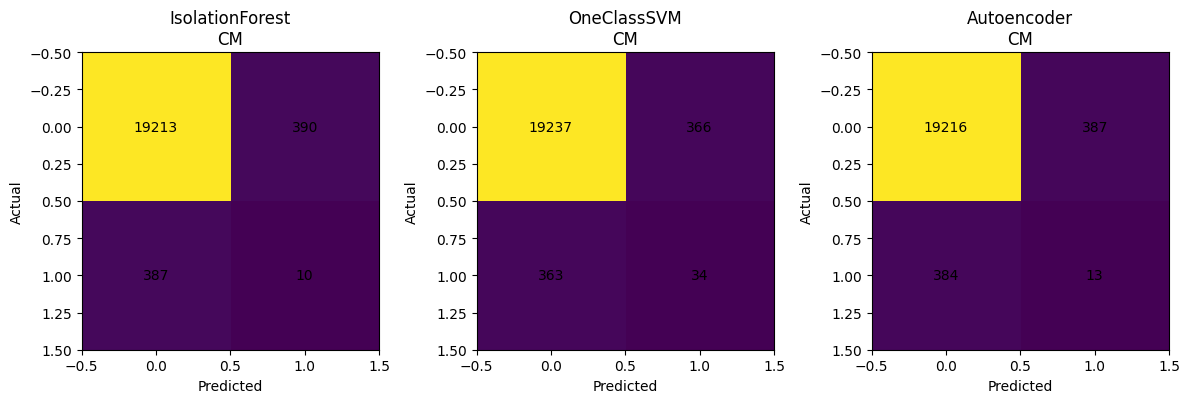

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,4))
for i, (name, scores) in enumerate(scores_map.items(), 1):
    thr = np.percentile(np.asarray(scores).ravel(), 100 * (1 - FRAUD_RATE))
    y_pred = (np.asarray(scores).ravel() >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, len(scores_map), i)
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name}\nCM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (r, c), val in np.ndenumerate(cm):
        plt.text(c, r, f"{val}", ha='center', va='center')
plt.tight_layout()
plt.show()


## Model Comparison & Cost-Sensitive Evaluation

This block evaluates **Isolation Forest**, **One-Class SVM**, and **Autoencoder** using a unified, business-aware metric framework.  
For each model, anomaly scores are converted into binary predictions using a threshold calibrated to the expected fraud rate (2%), and performance is compared using **PR-AUC (primary)**, **F1-score**, **Recall**, and a **cost-based metric** that penalizes false negatives more heavily than false positives.


Fraud detection is highly imbalanced and cost-sensitive: missing fraud (FN) is far more expensive than flagging a legitimate transaction (FP).  
By combining PR-AUC with F1 and an explicit cost function, this evaluation reflects **real-world deployment priorities**.

In [28]:
scores_map = {
    "IsolationForest": anomaly_score,   
    "OneClassSVM": ocsvm_scores,
    "Autoencoder": recon_error
}

FRAUD_RATE = 0.02
FN_COST = 10.0   
FP_COST = 1.0    

results = []

y_true = y_test.values if hasattr(y_test, "values") else np.array(y_test)

def compute_pr_auc(y, s):
    p, r, _ = precision_recall_curve(y, s)
    return auc_score(r, p)

for name, scores in scores_map.items():
    scores = np.asarray(scores).ravel()
    pr_auc_val = compute_pr_auc(y_true, scores)
    try:
        roc_auc_val = roc_auc_score(y_true, scores)
    except Exception:
        roc_auc_val = np.nan

    thr = np.percentile(scores, 100 * (1 - FRAUD_RATE))
    y_pred = (scores >= thr).astype(int)


    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = fn * FN_COST + fp * FP_COST

    results.append({
        "model": name,
        "pr_auc": pr_auc_val,
        "roc_auc": roc_auc_val,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "threshold": float(thr),
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "tn": int(tn),
        "cost": total_cost
    })

df_results = pd.DataFrame(results)

df_results = df_results.sort_values(["pr_auc", "f1"], ascending=False).reset_index(drop=True)

display_df = df_results.copy()
for c in ["pr_auc", "roc_auc", "precision", "recall", "f1", "threshold", "cost"]:
    display_df[c] = display_df[c].apply(lambda x: round(x, 4) if pd.notnull(x) else x)

print("Model comparison (sorted by PR-AUC desc):\n")
print(display_df[["model", "pr_auc", "f1", "recall", "precision", "cost", "tp", "fp", "fn", "tn"]].to_string(index=False))

print("\n\nDetailed reports:")
for row in results:
    name = row["model"]
    thr = row["threshold"]
    scores = scores_map[name]
    y_pred = (np.asarray(scores).ravel() >= thr).astype(int)
    print(f"\n=== {name} (threshold={thr:.6f}) ===")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))


Model comparison (sorted by PR-AUC desc):

          model  pr_auc     f1  recall  precision   cost  tp  fp  fn    tn
    OneClassSVM  0.0377 0.0853  0.0856     0.0850 3996.0  34 366 363 19237
    Autoencoder  0.0232 0.0326  0.0327     0.0325 4227.0  13 387 384 19216
IsolationForest  0.0225 0.0251  0.0252     0.0250 4260.0  10 390 387 19213


Detailed reports:

=== IsolationForest (threshold=0.016965) ===
Confusion matrix:
[[19213   390]
 [  387    10]]

Classification report:
              precision    recall  f1-score   support

           0     0.9803    0.9801    0.9802     19603
           1     0.0250    0.0252    0.0251       397

    accuracy                         0.9611     20000
   macro avg     0.5026    0.5026    0.5026     20000
weighted avg     0.9613    0.9611    0.9612     20000


=== OneClassSVM (threshold=6.853425) ===
Confusion matrix:
[[19237   366]
 [  363    34]]

Classification report:
              precision    recall  f1-score   support

           0     0.98

## MODEL CONCLUSION AND JUSTIFICATION

- model chosen: OneClassSVM.
- justification : 
 - - It achieved the highest PR-AUC (0.0377), which is the most reliable metric for highly imbalanced fraud data.

 - - It produced the best F1-score (0.0853), indicating the best balance between precision and recall.

 - - It captured the highest recall (0.0856), meaning it detected more actual fraud cases than the other models.

In [29]:
import joblib
import os


# Save One-Class SVM model
joblib.dump(ocsvm, "one_class_svm.pkl")

# Save the scaler used during training (CRITICAL for inference)
joblib.dump(scaler, "robust_scaler.pkl")

print("One-Class SVM model and scaler saved successfully.")


One-Class SVM model and scaler saved successfully.
